# Setup

In [1]:
pip install -r ../../requirements.txt

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple/, https://****@pkgs.dev.azure.com/parsionate-ai/ps-libraries/_packaging/pypi-feed/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '../..')

In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [5]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-06-06 15:39:48.513298: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
config = json.load(open("./configs/mnn_btl_amazon.json"))

# Loading data

In [7]:
from data_loader.abo import ABO

In [8]:
data = ABO(path=config["data"]["path"],
           download=True,
           extract=False,
           preprocess=True,
           alt_augment=False,
           random_deletion=False,
           export_csv=True).data

# data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
# data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,drink-mixesb08563lhffamazon brand - solimo des...,54/54df5424.jpg,CELLULAR_PHONE_CASE,0
1,back coverb0856b8fh6amazon brand - solimo desi...,bd/bd44e6bb.jpg,CELLULAR_PHONE_CASE,1
2,cellphonecoverb0853wv4hcamazon brand - solimo ...,64/649813ae.jpg,CELLULAR_PHONE_CASE,1
3,realme c3 360 coverb08563lgbqamazon brand - so...,57/57d3c65a.jpg,CELLULAR_PHONE_CASE,1
4,"mobile coverb07tf1g7b7365 everyday value, extr...",ed/edac77b6.jpg,SANDAL,0
...,...,...,...,...
168163,back coverb0856bj46famazon brand - solimo desi...,e3/e36413d0.jpg,CELLULAR_PHONE_CASE,1
168164,mobile coverb0854fkp7ramazon brand rivet velv...,bc/bcbdb6f8.jpg,CELLULAR_PHONE_CASE,0
168165,mobile coverb07th32b19amazon brand - solimo de...,76/76bab295.jpg,CELLULAR_PHONE_CASE,1
168166,back coverb07t8px6bjamazon brand - solimo desi...,90/909a8782.jpg,CELLULAR_PHONE_CASE,0


In [9]:
img = data[["path"]]  # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [10]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(168168, 1014)

## Create embedding weights

In [11]:
weights = tk.create_embedding_weights()
weights.shape

(65, 64)

# Image processing

## Load image model

In [12]:
from utils.img_processing import load_img_model, create_embeddings_from

In [13]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [ ]:
# Mobilenetv3small:
# batch_size = 1024 -> 8 GB VRAM
# batch_size = 2048 -> 16 GB VRAM
# ...
# Mobilenetv3large: twice as much as Mobilenetv3small

img = create_embeddings_from(img_model,
                             img,
                             os.path.join(config["data"]["path"],
                                          "images/small"),
                             batch_size=1024)

Found 168171 validated image filenames.


In [15]:
img.shape

(168171, 576)

# Save embeddings

In [14]:
save_path = os.path.join(config["data"]["path"],
                         f"embeddings/{img_model.name}")

In [ ]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [15]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,saladb0853x6hzpamazon brand - symbol men's gre...,11/11cc4b59.jpg,CELLULAR_PHONE_CASE,0
1,cellphonecoverb0853xv3f7amazon brand - solimo ...,1a/1a82adfa.jpg,CELLULAR_PHONE_CASE,1
2,cellphonecoverb07tbv7qxramazon brand: find mye...,58/58116648.jpg,GROCERY,0
3,back coverb08548cp7yamazon brand - solimo desi...,37/3706b09a.jpg,CELLULAR_PHONE_CASE,1
4,back coverb075m4x9b1pinzon 7'6 x 9'6 hand-tuft...,bf/bfada426.jpg,JUICE_AND_JUICE_DRINK,0
...,...,...,...,...
168166,mobile coverb07tc6mfl9amazon brand - solimo de...,c7/c78bee83.jpg,CELLULAR_PHONE_CASE,1
168167,mobile coverb07t6mcb1qamazon brand - solimo de...,b8/b895a604.jpg,CELLULAR_PHONE_CASE,1
168168,zapatos shoe para de ladies mujer womans mocas...,a8/a89a52f5.jpg,HEADBOARD,0
168169,classics with a twistb00vr99kfyyellow gold ove...,e4/e4bc17ab.jpg,NECKLACE,1


In [16]:
img = np.load(f"{save_path}/img.npy", allow_pickle=True)
img.shape

(168171, 576)

In [17]:
text = np.load(f"{save_path}/text.npy", allow_pickle=True)
text.shape

(168171, 1014)

# Train-Test Split

## Split into ground truth/false samples

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [18]:
ground_truth = data[data["label"] == 1]
false_samples = data[data["label"] == 0]
data = ground_truth
data

,description,path,product_type,label
1,cellphonecoverb0853xv3f7amazon brand - solimo ...,1a/1a82adfa.jpg,CELLULAR_PHONE_CASE,1
3,back coverb08548cp7yamazon brand - solimo desi...,37/3706b09a.jpg,CELLULAR_PHONE_CASE,1
7,dining table 6 seater wooden extendable room a...,41/4137a448.jpg,TABLE,1
8,mobile coverb07tg4vzbbamazon brand - solimo de...,79/79814a0f.jpg,CELLULAR_PHONE_CASE,1
9,herbal tea extractb07sdgh5bpamazon brand - hap...,a8/a8e1c9ab.jpg,GROCERY,1
...,...,...,...,...
168164,classics with a twistb005z8byzmstainless steel...,ad/ad1c5eac.jpg,NECKLACE,1
168166,mobile coverb07tc6mfl9amazon brand - solimo de...,c7/c78bee83.jpg,CELLULAR_PHONE_CASE,1
168167,mobile coverb07t6mcb1qamazon brand - solimo de...,b8/b895a604.jpg,CELLULAR_PHONE_CASE,1
168169,classics with a twistb00vr99kfyyellow gold ove...,e4/e4bc17ab.jpg,NECKLACE,1


In [19]:
false_samples

,description,path,product_type,label
0,saladb0853x6hzpamazon brand - symbol men's gre...,11/11cc4b59.jpg,CELLULAR_PHONE_CASE,0
2,cellphonecoverb07tbv7qxramazon brand: find mye...,58/58116648.jpg,GROCERY,0
4,back coverb075m4x9b1pinzon 7'6 x 9'6 hand-tuft...,bf/bfada426.jpg,JUICE_AND_JUICE_DRINK,0
5,shoesb07tc5f646amazon brand - solimo designer ...,63/638dd86c.jpg,CELLULAR_PHONE_CASE,0
6,mobile coverb0856b3yb4amazon brand - solimo de...,76/763b5192.jpg,CELLULAR_PHONE_CASE,0
...,...,...,...,...
168159,"toilet handle replacement, toilet handle, toil...",d1/d1f9a5f5.jpg,SHOES,0
168160,"chaib07tf1bqbs365 everyday value, whole vitami...",94/945cbb16.jpg,SHOES,0
168162,"mobile coverb07nld7f91whole foods market, bun ...",7d/7d01da95.jpg,HEADBOARD,0
168165,mobile coverb086vymgqmamazon brand - solimo de...,6c/6c35dc54.jpg,CELLULAR_PHONE_CASE,0


In [20]:
img_false = img[false_samples.index]
text_false = text[false_samples.index]

In [21]:
img = img[data.index]
text = text[data.index]

In [22]:
data = data.reset_index(drop=True)
false_samples = false_samples.reset_index(drop=True)

In [23]:
img.shape

(87380, 576)

In [24]:
img_false.shape

(80791, 576)

## Ground truth

In [25]:
data["product_type_count"] = data.groupby(
    ["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [26]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train, test, product_types_train, product_types_test = train_test_split(
    data,
    product_types,
    stratify=product_types,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [29]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

## False samples

In [30]:
false_samples["product_type_count"] = false_samples.groupby(
    ["product_type"])["product_type"].transform("count")

false_samples = false_samples[false_samples["product_type_count"] > config["data"]["cls"]]

In [31]:
# Update both columns
product_types_false = false_samples[["product_type"]]

labels_false = false_samples[["label"]]

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
train_false, test_false, product_types_train_false, product_types_test_false = train_test_split(
    false_samples,
    product_types_false,
    stratify=product_types_false,
    test_size=config["model"]["training"]["test_split"],
    random_state=42)

In [34]:
img_train_false = img_false[train_false.index]
img_test_false = img_false[test_false.index]

text_train_false = text_false[train_false.index]
text_test_false = text_false[test_false.index]

# Save Char CNN config

In [35]:
from models.char_cnn_zhang import CharCNNZhang

In [36]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [37]:
char_cnn = CharCNNZhang(**char_cnn_config)

# Build MNN-BTL Model

In [38]:
from models.mnn_btl import MNNBTL
from utils.metrics import create_metrics

In [39]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "img_fc_layers": config["model"]["img_fc_layers"],
    "txt_fc_layers": config["model"]["txt_fc_layers"],
    "extended": False,
}

In [40]:
mnn_btl = MNNBTL(
    head_config=head_config,
    char_cnn=char_cnn.model,
    learning_rate=config["model"]["training"]["learning_rate"])

In [41]:
mnn_btl.model.summary(expand_nested=True)

Model: "MNN_BTL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input_Head_Outer (InputL  [(None, 576)]       0           []                               
 ayer)                                                                                            
                                                                                                  
 Text_Input_Head_Outer (InputLa  [(None, 1014)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Image_CNN (Functional)         (None, 512)          1115648     ['Image_Input_Head_Outer[0][0]'] 
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

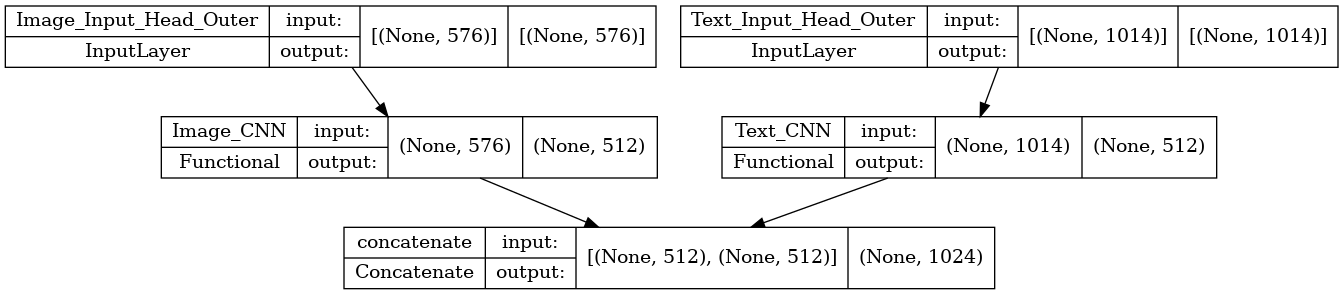

In [42]:
# "Head"

tf.keras.utils.plot_model(mnn_btl.model,
                          rankdir="TB",
                          show_layer_activations=True,
                          show_shapes=True)

# Callbacks

In [43]:
from utils.metrics import create_callbacks

In [44]:
log_dir = config["model"]["training"]["log_dir"]
model_name = config["model"]["name"]
optimizer_name = config["model"]["training"]["optimizer"]
learning_rate = config["model"]["training"]["learning_rate"]

In [45]:
callbacks = create_callbacks(
    callbacks_list=config["model"]["training"]["callbacks"],
    log_dir=log_dir,
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"],
    patience=10)

# Class weights

In [46]:
from sklearn.utils import class_weight

In [47]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=product_types_train["product_type"].unique(),
                                                 y=product_types_train["product_type"])
len(class_weights)

341

In [48]:
class_weights_dict = {}
class_weights_dict_transform = {}
i = 0

for pt, cw in zip(product_types_train["product_type"].unique(), class_weights):
    class_weights_dict[i] = cw
    class_weights_dict_transform[pt] = i
    i += 1
    
len(class_weights_dict)

341

In [49]:
len(class_weights_dict_transform)

341

In [50]:
product_types_train["product_type_transform"] = product_types_train["product_type"].apply(lambda x: class_weights_dict_transform[x])
product_types_train

,product_type,product_type_transform
35508,CELLULAR_PHONE_CASE,0
63763,CELLULAR_PHONE_CASE,0
20077,RUG,1
51575,CELLULAR_PHONE_CASE,0
32058,CELLULAR_PHONE_CASE,0
...,...,...
63970,CELLULAR_PHONE_CASE,0
34006,CELLULAR_PHONE_CASE,0
42833,BEAUTY,40
48890,SCREEN_PROTECTOR,46


In [51]:
class_weights_dict[0]

0.003965354505579923

# Training

In [52]:
history = mnn_btl.model.fit(
    x=[img_train, text_train],
    y=product_types_train["product_type_transform"],
    epochs=config["model"]["training"]["epochs"],
    validation_split=config["model"]["training"]["validation_split"],
    batch_size=config["model"]["training"]["batch_size"],
    class_weight=class_weights_dict,
    callbacks=callbacks)

Epoch 1/10
4420/4420 [==============================] - ETA: 0s - loss: 0.6160

2023-06-06 15:41:16.286846: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 60s 13ms/step - loss: 0.6160 - val_loss: 0.0285
Epoch 2/10
4415/4420 [============================>.] - ETA: 0s - loss: 0.0248

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 54s 12ms/step - loss: 0.0248 - val_loss: 0.0256
Epoch 3/10
4420/4420 [==============================] - ETA: 0s - loss: 0.0238

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 55s 12ms/step - loss: 0.0238 - val_loss: 0.0244
Epoch 4/10
4420/4420 [==============================] - 49s 11ms/step - loss: 0.0242 - val_loss: 0.0252
Epoch 5/10
4417/4420 [============================>.] - ETA: 0s - loss: 0.0233

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 59s 13ms/step - loss: 0.0233 - val_loss: 0.0234
Epoch 6/10
4420/4420 [==============================] - 55s 12ms/step - loss: 0.0226 - val_loss: 0.0245
Epoch 7/10
4420/4420 [==============================] - 55s 12ms/step - loss: 0.0224 - val_loss: 0.0244
Epoch 8/10
4420/4420 [==============================] - 55s 12ms/step - loss: 0.0217 - val_loss: 0.0234
Epoch 9/10
4420/4420 [==============================] - 55s 12ms/step - loss: 0.0218 - val_loss: 0.0236
Epoch 10/10
4418/4420 [============================>.] - ETA: 0s - loss: 0.0214

INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_BTL_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


4420/4420 [==============================] - 61s 14ms/step - loss: 0.0214 - val_loss: 0.0231


# Evaluation

## Plot loss and metrics

In [53]:
from utils.metrics import plot_metrics

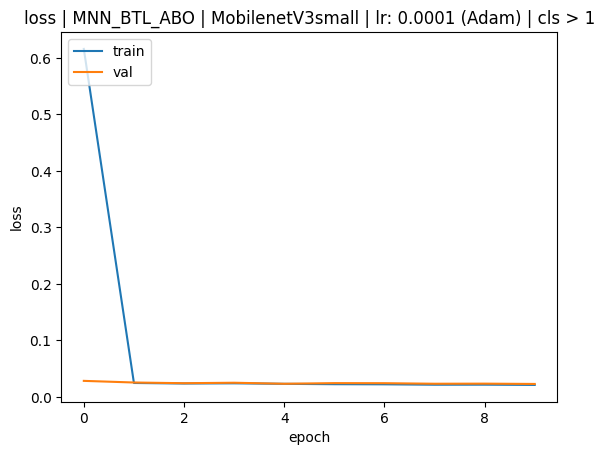

In [54]:
plot_metrics(history.history, [],
             model_name, img_model.name, optimizer_name, learning_rate,
             config["data"]["cls"])

## Evaluate model and save metrics

In [55]:
from utils.metrics import evaluate

In [56]:
test_merged = pd.concat([test.reset_index(drop=True), test_false.reset_index(drop=True)])
img_test_merged = np.concatenate([img_test, img_test_false])
text_test_merged = np.concatenate([text_test, text_test_false])
print(test_merged.shape, img_test_merged.shape, text_test_merged.shape)

(16801, 5) (16801, 576) (16801, 1014)


In [57]:
evaluate(mnn_btl.model, [img_test_merged, text_test_merged], test_merged[["label"]], log_dir, model_name,
         img_model.name, optimizer_name, learning_rate, config["data"]["cls"], triplet_model=True)

16801/16801 [==============================] - 32s 2ms/step - loss: 0.0698
